In [1]:
from glob import glob
from os import listdir
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import reframed
from reframed.cobra.ensemble import load_ensemble
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from cobra.medium import minimal_medium
from statistics import median

In [2]:
class ModelsInfo:
    """Summary table of carveme and curated models of SAME strain

    Parameters
    ----------
    StrainName: str, default=None
        Must be the initial of the genus,
        followed by the specific term of the species
        (e.g. Bacteroides thetaiotaomicron -> Bthetaiotaomicron)

    Template: list, {"universal", "gram"}, default=None
    GapProcess: list, {"gapAfter", "gapDuring", "NoGap"}, default=None
    Medium: list, {"M9", "LB", "NoMedium"}, default=None

    CuratedModel: str, {"curated"}, default=None
        If a curated model exists, the file must have 
        "curated" in the name
    """
    
    def __init__(self, StrainName=None,Template=None, GapProcess=None, Medium=None, *, CuratedModel=None):
        self.StrainName=StrainName
        self.Template=Template
        self.GapProcess=GapProcess
        self.Medium=Medium
        self.CuratedModel=CuratedModel
    
    def getFilesNamesList(self):
        '''Returns a list of filenames from models
        with **same Template and same GapProcess**
        and from curated models
        
        fileName example: "Bthetaiotaomicron_gram_gapAfter_M9.xml.gz"
        '''
    
        filesNamesList=[]
        Files = '*.xml.gz'
        carvemeVars=[self.StrainName, self.Template, self.GapProcess, self.Medium]
        if all(carvemeVar is not None for carvemeVar in carvemeVars): #if none of these is None
            for fileName in glob(Files):
                if "Ensemble" not in fileName:
                    if self.StrainName in fileName:
                        for template in self.Template:
                            if template in fileName:
                                for gapP in self.GapProcess:
                                    if gapP in fileName:
                                        for medium in self.Medium:
                                            if medium in fileName:
                                                filesNamesList.append(fileName)
        CuratedFiles = '*.xml'
        curatedVars=[self.StrainName, self.CuratedModel]
        if all(curatedVar is not None for curatedVar in curatedVars):
            for curatedFileName in glob(CuratedFiles):
                if self.StrainName in curatedFileName:
                    if self.CuratedModel in curatedFileName:
                        filesNamesList.append(curatedFileName)
        return filesNamesList
    
    def modelsAnalysis(self):
        '''Makes dataframe with basic analysis of models
           except of curated models with LB and M9 media
        '''
        
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['analysis']) 
            modelsDataframes=[]
            for fileName in filesList:
                model=read_sbml_model(fileName)  
                ModelData=[]
                FBAsolution=model.optimize()
                FBA=FBAsolution.objective_value
                fbaRow=['Growth rate', FBA]
                ModelData.append(fbaRow)
                FastaProteins=4636
                aRow=['Fasta Proteins', FastaProteins]
                ModelData.append(aRow)
                GenesList=[]
                for x in model.genes:
                    GenesList.append(x.id)   
                GenesNo=len(GenesList)
                bRow=['Gene/Protein no.', GenesNo]
                ModelData.append(bRow)
                essentGenes=cobra.flux_analysis.find_essential_genes(model, threshold=None, processes=None)
                essentGenesList=[]
                for gene in essentGenes:
                    essentGenesList.append(gene.id)
                if "spontaneous" in essentGenesList:
                    essentGenesList.remove("spontaneous")
                essentGenesNo=len(essentGenesList)
                essentRow=['Essential genes', essentGenesNo]
                ModelData.append(essentRow)
                RxNo=len(model.reactions)
                cRow=['Reactions no.', RxNo]
                ModelData.append(cRow)

                UBlockedRxs=cobra.flux_analysis.find_blocked_reactions(model, reaction_list=None, zero_cutoff=None, open_exchanges=True, processes=None)
                UBlockedRxsNo=len(UBlockedRxs)
                UBlockedRow=['Universally blocked rxs', UBlockedRxsNo]
                ModelData.append(UBlockedRow)

                SpecifBlockedRxs=cobra.flux_analysis.find_blocked_reactions(model, reaction_list=None, zero_cutoff=None, open_exchanges=False, processes=None)
                SpecifBlockedRxsNo=len(SpecifBlockedRxs)
                SpecifBlockedRxsRow=['Medium specific blocked rxs', SpecifBlockedRxsNo]
                ModelData.append(SpecifBlockedRxsRow)

                rxFluxesSeries=FBAsolution.fluxes
                rxFluxesDF=pd.DataFrame(rxFluxesSeries, columns=['fluxes'])
                zerofluxRows=rxFluxesDF[rxFluxesDF['fluxes'] == float(0)]
                zeroFluxRxs=list(zerofluxRows.index.values)
                ZeroFluxNo=len(zeroFluxRxs)
                ZeroFluxNoRow=['Zero flux rxs', ZeroFluxNo]
                ModelData.append(ZeroFluxNoRow)
                
                blockedNumber = len(set(SpecifBlockedRxs).intersection(set(zeroFluxRxs)))
                BlockedPerc=blockedNumber/RxNo*100
                BlockedPercRow=['% of blocked rxs', BlockedPerc]
                ModelData.append(BlockedPercRow)

                ZeroFluxPerc=ZeroFluxNo/RxNo*100
                ZeroFluxPercRow=['% of zero flux rxs', ZeroFluxPerc]
                ModelData.append(ZeroFluxPercRow)

                ExRxNo=len(model.exchanges)
                eRow=['Exchange rxs', ExRxNo]
                ModelData.append(eRow)
                
                MediumL=[v for v in model.medium.keys()]
                mediumExRx=len(MediumL)
                mediumRow=['Exchange rxs with active flux', mediumExRx]
                ModelData.append(mediumRow)
                
                ActiveExDF=rxFluxesDF.loc[MediumL]
#                 nzfluxRow=ActiveExDF[ActiveExDF['fluxes'] != float(0)]
                nzfluxRowABS=ActiveExDF.abs()
                nzActiveExMean=nzfluxRowABS['fluxes'].mean()
#                 nzActiveExMean=median(sorted(nzActiveExMean))
                if "Growth" in list(ActiveExDF.index.values):
                    activeExNonZeroFlux-=1
                    activeEx_noGrowth = nzfluxRowABS.drop('Growth')
                    nzActiveExMean=activeEx_noGrowth['fluxes'].mean()  
                nzActiveExMeanRow=['Exchange rxs with active flux - mean', nzActiveExMean]
                ModelData.append(nzActiveExMeanRow)
                
                reactionsIDsList=[]
                for reaction in model.reactions:
                    reactionsIDsList.append(reaction.id)
                TranspRxsINmodel=[]
                transp=pd.read_excel('UnivNGramTranspRxs.xlsx')
                transpList=transp['RxID'].tolist()
                EnzymaticRxsGPR=[]
                for rx in reactionsIDsList:
                    if rx in transpList:
                        TranspRxsINmodel.append(rx)
                    getReaction=model.reactions.get_by_id(rx)
                    SpecificGPRrule = getReaction.gene_reaction_rule
                    if SpecificGPRrule:
                        EnzymaticRxsGPR.append(SpecificGPRrule)
                TranspRxs=len(TranspRxsINmodel)
                dRow=['Transport rxs', TranspRxs]
                ModelData.append(dRow)
                boundaryRxsID=[]
                for brx in model.boundary:
                    boundaryRxsID.append(brx.id)
                MetabolicRxsList=list(set(reactionsIDsList) - set(boundaryRxsID) - set(TranspRxsINmodel))
                MetabolicRxs=len(MetabolicRxsList)-1 #1 is the number of growth reaction
                gRow=['Purely metabolic rxs', MetabolicRxs]
                ModelData.append(gRow)
                
                MetabRxDF=rxFluxesDF.loc[MetabolicRxsList]
                nonZerofluxRows=MetabRxDF[MetabRxDF['fluxes'] != float(0)]
                MetabolicNonZeroFlux=len(nonZerofluxRows)
                nonZerofluxRowsABS=nonZerofluxRows.abs()
                nzMean=nonZerofluxRowsABS['fluxes'].mean()
                if "Growth" in list(nonZerofluxRows.index.values):
                    MetabolicNonZeroFlux-=1
                    nonZerofluxRx_noGrowth = nonZerofluxRowsABS.drop('Growth')
                    nzMean=nonZerofluxRx_noGrowth['fluxes'].mean()
                nzMetabRxsRow=['Purely metabolic rxs with non-zero flux', MetabolicNonZeroFlux]
                ModelData.append(nzMetabRxsRow)
                
                nzMeanRow=['Purely metabolic rxs with non-zero flux - mean', nzMean]
                ModelData.append(nzMeanRow)
                
                GPRno=len(EnzymaticRxsGPR)
                fRow=['GPR no./enzymatic reactions no.', GPRno]
                ModelData.append(fRow)
                
                EnzymaticMetabRxsGPR=[]
                for EMRx in MetabolicRxsList:
                    getEMRx=model.reactions.get_by_id(EMRx)
                    SpecificEMRxGPR = getEMRx.gene_reaction_rule
                    if SpecificEMRxGPR:
                        EnzymaticMetabRxsGPR.append(SpecificEMRxGPR)
                EMRxGPRno=len(EnzymaticMetabRxsGPR)
                EMRxGPRrow=['purely metabolic reactions that have genes associated - enzymatic', EMRxGPRno]
                ModelData.append(EMRxGPRrow)
                
                modelName=fileName.replace(".gz", '')
                modelName=modelName.replace(".xml", '')
                modelDF=pd.DataFrame(ModelData, columns=['analysis',  modelName]) 
                modelsDataframes.append(modelDF)
            for each_DF in modelsDataframes:
                modelsDF=pd.merge(each_DF, modelsDF, on='analysis', how='outer').fillna(False)
            modelsDF=modelsDF.round(1)
            
        else: #if there is no file name
#             modelsDF=pd.DataFrame() #make empty dataframe
            modelsDF=None
            
        return modelsDF
    
    def curatedMinimalMedium(self):
        '''makes series with minimal medium for curated model'''
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        model=read_sbml_model(fileName)  
                        model.optimize()
                        #for M9 and LB, no oxygen
                        model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                        model.optimize()
                        #function "minimal_medium" to get minimal medium [-O2] composition for curated model to grow
#                         M9Series=minimal_medium(model, 0.8, minimize_components=1, open_exchanges=False)
#                         M9Series.to_excel('BthetaCuratedMinimalMedium.xlsx')
                        M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
                        M9List=M9Series.index.tolist()
                        Media=pd.read_excel('carvemeMedia.xlsx')
                        M9CarvemeMedium=Media['M9'].tolist()
                        CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
                        self.M9Medium=M9List+CarvemeM9Metabs
                        LBmediumList=Media['LB'].tolist()
                        LBmedium=LBmediumList+self.M9Medium
                        self.LBmedium=list(set(LBmedium))
                        Media=[self.M9Medium, self.LBmedium]
                else:
                    Media=None
            
        return Media
    
    
    def curatedModelsAnalysis(self):
        '''Makes dataframe with basic analysis of curated models
           with LB and M9 media
        '''

        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['analysis']) 
            modelsDataframes=[]
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        Media=self.curatedMinimalMedium()
                        for medium in Media:
                            if medium == self.M9Medium:
                                mediumName="M9"
                            elif medium == self.LBmedium:
                                mediumName ="LB"
                            model=read_sbml_model(fileName)  
                            model.optimize()
                            MediumList=[v for v in model.medium.keys()] # has all Exchange reactions active
                            MediumList.remove("EX_glc(e)")
                            model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                            for mediumRx in MediumList: #go through each reaction in medium
                                if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
                                    model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
                            ModelData=[]
                            for Ex_rx in model.medium.keys():
                                model.reactions.get_by_id(Ex_rx).lower_bound = -10
                                model.reactions.get_by_id(Ex_rx).upper_bound = 1000
                            FBAsolution=model.optimize()
                            FBA=FBAsolution.objective_value
                            fbaRow=['Growth rate', FBA]
                            ModelData.append(fbaRow)
                            FastaProteins=4636
                            aRow=['Fasta Proteins', FastaProteins]
                            ModelData.append(aRow)
                            GenesList=[]
                            for x in model.genes:
                                GenesList.append(x.id)   
                            GenesNo=len(GenesList)
                            bRow=['Gene/Protein no.', GenesNo]
                            ModelData.append(bRow)
                            essentGenes=cobra.flux_analysis.find_essential_genes(model, threshold=None, processes=None)
                            essentGenesList=[]
                            for gene in essentGenes:
                                essentGenesList.append(gene.id)
                            if "spontaneous" in essentGenesList:
                                essentGenesList.remove("spontaneous")
                            essentGenesNo=len(essentGenesList)
                            essentRow=['Essential genes', essentGenesNo]
                            ModelData.append(essentRow)
                            RxNo=len(model.reactions)
                            cRow=['Reactions no.', RxNo]
                            ModelData.append(cRow)

                            UBlockedRxs=cobra.flux_analysis.find_blocked_reactions(model, reaction_list=None, zero_cutoff=None, open_exchanges=True, processes=None)
                            UBlockedRxsNo=len(UBlockedRxs)
                            UBlockedRow=['Universally blocked rxs', UBlockedRxsNo]
                            ModelData.append(UBlockedRow)

                            SpecifBlockedRxs=cobra.flux_analysis.find_blocked_reactions(model, reaction_list=None, zero_cutoff=None, open_exchanges=False, processes=None)
                            SpecifBlockedRxsNo=len(SpecifBlockedRxs)
                            SpecifBlockedRxsRow=['Medium specific blocked rxs', SpecifBlockedRxsNo]
                            ModelData.append(SpecifBlockedRxsRow)

                            rxFluxesSeries=FBAsolution.fluxes
                            rxFluxesDF=pd.DataFrame(rxFluxesSeries, columns=['fluxes'])
                            zerofluxRows=rxFluxesDF[rxFluxesDF['fluxes'] == float(0)]
                            zeroFluxRxs=list(zerofluxRows.index.values)
                            ZeroFluxNo=len(zeroFluxRxs)
                            ZeroFluxNoRow=['Zero flux rxs', ZeroFluxNo]
                            ModelData.append(ZeroFluxNoRow)

                            blockedNumber = len(set(SpecifBlockedRxs).intersection(set(zeroFluxRxs)))
                            BlockedPerc=blockedNumber/RxNo*100
                            BlockedPercRow=['% of blocked rxs', BlockedPerc]
                            ModelData.append(BlockedPercRow)

                            ZeroFluxPerc=ZeroFluxNo/RxNo*100
                            ZeroFluxPercRow=['% of zero flux rxs', ZeroFluxPerc]
                            ModelData.append(ZeroFluxPercRow)

                            ExRxNo=len(model.exchanges)
                            eRow=['Exchange rxs', ExRxNo]
                            ModelData.append(eRow)

                            MediumL=[v for v in model.medium.keys()]
                            mediumExRx=len(MediumL)
                            mediumRow=['Exchange rxs with active flux', mediumExRx]
                            ModelData.append(mediumRow)
                            
                            ActiveExDF=rxFluxesDF.loc[MediumL]
#                             nzfluxRow=ActiveExDF[ActiveExDF['fluxes'] != float(0)]
                            nzfluxRowABS=ActiveExDF.abs()
                            nzActiveExMean=nzfluxRowABS['fluxes'].mean()
                            if "Growth" in list(ActiveExDF.index.values):
                                activeExNonZeroFlux-=1
                                activeEx_noGrowth = nzfluxRowABS.drop('Growth')
                                nzActiveExMean=activeEx_noGrowth['fluxes'].mean()  
                            nzActiveExMeanRow=['Exchange rxs with active flux - mean', nzActiveExMean]
                            ModelData.append(nzActiveExMeanRow)

                            reactionsIDsList=[]
                            for reaction in model.reactions:
                                reactionsIDsList.append(reaction.id)
                            TranspRxsINmodel=[]
                            transp=pd.read_excel('UnivNGramTranspRxs.xlsx')
                            transpList=transp['RxID'].tolist()
                            EnzymaticRxsGPR=[]
                            for rx in reactionsIDsList:
                                if rx in transpList:
                                    TranspRxsINmodel.append(rx)
                                getReaction=model.reactions.get_by_id(rx)
                                SpecificGPRrule = getReaction.gene_reaction_rule
                                if SpecificGPRrule:
                                    EnzymaticRxsGPR.append(SpecificGPRrule)
                            TranspRxs=len(TranspRxsINmodel)
                            dRow=['Transport rxs', TranspRxs]
                            ModelData.append(dRow)
                            boundaryRxsID=[]
                            for brx in model.boundary:
                                boundaryRxsID.append(brx.id)
                            MetabolicRxsList=list(set(reactionsIDsList) - set(boundaryRxsID) - set(TranspRxsINmodel))
                            MetabolicRxs=len(MetabolicRxsList)-1
                            gRow=['Purely metabolic rxs', MetabolicRxs]
                            ModelData.append(gRow)
                            
                            MetabRxDF=rxFluxesDF.loc[MetabolicRxsList]
                            nonZerofluxRows=MetabRxDF[MetabRxDF['fluxes'] != float(0)]
                            MetabolicNonZeroFlux=len(nonZerofluxRows)
                            nonZerofluxRowsABS=nonZerofluxRows.abs()
                            nzMean=nonZerofluxRowsABS['fluxes'].mean()
                            if "Growth" in list(nonZerofluxRows.index.values):
                                MetabolicNonZeroFlux-=1
                                nonZerofluxRx_noGrowth = nonZerofluxRowsABS.drop('Growth')
                                nzMean=nonZerofluxRx_noGrowth['fluxes'].mean()
                            nzMetabRxsRow=['Purely metabolic rxs with non-zero flux', MetabolicNonZeroFlux]
                            ModelData.append(nzMetabRxsRow)
                            nzMeanRow=['Purely metabolic rxs with non-zero flux - mean', nzMean]
                            ModelData.append(nzMeanRow)
                            
                            GPRno=len(EnzymaticRxsGPR)
                            fRow=['GPR no.', GPRno]
                            ModelData.append(fRow)
                            
                            EnzymaticMetabRxsGPR=[]
                            for EMRx in MetabolicRxsList:
                                getEMRx=model.reactions.get_by_id(EMRx)
                                SpecificEMRxGPR = getEMRx.gene_reaction_rule
                                if SpecificEMRxGPR:
                                    EnzymaticMetabRxsGPR.append(SpecificEMRxGPR)
                            EMRxGPRno=len(EnzymaticMetabRxsGPR)
                            EMRxGPRrow=['purely metabolic reactions that have genes associated - enzymatic', EMRxGPRno]
                            ModelData.append(EMRxGPRrow)
                            
                            modelName=fileName.replace(".xml", '')
                            modelDF=pd.DataFrame(ModelData, columns=['analysis',  modelName + mediumName]) 
                            modelsDataframes.append(modelDF)
                        for each_DF in modelsDataframes:
                            modelsDF=pd.merge(each_DF, modelsDF, on='analysis', how='outer').fillna(False)
                        modelsDF=modelsDF.round(1)
                else:
                    modelsDF=None
        else: #if there is no file name
            modelsDF=None
        return modelsDF

    def joinDataframes(self):
        '''Joins carveme models table with curated models one
        '''
        generalmodelsDF=self.modelsAnalysis()
        curatedDF=self.curatedModelsAnalysis()
        dataframes=[generalmodelsDF, curatedDF]
            
        if all(df is not None for df in dataframes): #if none of the dataframes is None
            generalmodelsDF=generalmodelsDF.set_index('analysis')
            curatedDF=curatedDF.set_index('analysis')
            jointDF=generalmodelsDF.join(curatedDF, on='analysis')
            
        elif all(df is None for df in dataframes): #if all dataframes are None
            jointDF=pd.DataFrame() #empty dataframe
            
        elif generalmodelsDF is None:
            jointDF=curatedDF
            
        elif curatedDF is None:
            jointDF=generalmodelsDF
            
        return jointDF

In [3]:
# y=ModelsInfo(StrainName="Bthetaiotaomicron",Template=None,GapProcess=None, Medium=None, CuratedModel="curated")
# y.joinDataframes()

y=ModelsInfo(StrainName="Bthetaiotaomicron",Template=['gram'],GapProcess=['gapAfter', 'NoGap'], Medium=['NoMedium', 'LB', 'M9'], CuratedModel="curated")
y.joinDataframes()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


,Bthetaiotaomicron_curated,Bthetaiotaomicron_gram_NoGap_NoMedium,Bthetaiotaomicron_gram_gapAfter_M9,Bthetaiotaomicron_gram_gapAfter_LB,Bthetaiotaomicron_curatedLB,Bthetaiotaomicron_curatedM9
analysis,,,,,,
Growth rate,86.8,55.0,0.9,1.4,5.7,1.7
Fasta Proteins,4636.0,4636.0,4636.0,4636.0,4636.0,4636.0
Gene/Protein no.,993.0,832.0,832.0,832.0,993.0,993.0
Essential genes,61.0,40.0,120.0,67.0,124.0,200.0
Reactions no.,1528.0,2151.0,2155.0,2154.0,1528.0,1528.0
Universally blocked rxs,89.0,55.0,55.0,55.0,89.0,89.0
Medium specific blocked rxs,89.0,55.0,760.0,685.0,530.0,540.0
Zero flux rxs,945.0,1825.0,1774.0,1833.0,843.0,920.0
% of blocked rxs,5.8,2.6,35.3,31.8,33.2,35.3


# Heatmap with models' media composition

In [23]:
class MediumComposition:
    """Composition of media.
    
    Parameters
    ----------
    StrainName: str, default=None
        Must be the initial of the genus,
        followed by the specific term of the species
        (e.g. Bacteroides thetaiotaomicron -> Bthetaiotaomicron)

    Template: list, {"universal", "gram"}, default=None
    GapProcess: list, {"gapAfter", "gapDuring", "NoGap"}, default=None
    Medium: list, {"M9", "LB", "NoMedium"}, default=None

    CuratedModel: str, {"curated"}, default=None
        If a curated model exists, the file must have 
        "curated" in the name
    """
    
    def __init__(self, StrainName=None,Template=None, GapProcess=None, Medium=None, *, CuratedModel=None):
        self.StrainName=StrainName
        self.Template=Template
        self.GapProcess=GapProcess
        self.Medium=Medium
        self.CuratedModel=CuratedModel
    
    def getFilesNamesList(self):
        '''Returns a list of filenames from models
        with **same Template and same GapProcess**
        and from curated models
        
        fileName example: "Bthetaiotaomicron_gram_gapAfter_M9.xml.gz"
        '''
    
        filesNamesList=[]
        Files = '*.xml.gz'
        carvemeVars=[self.StrainName, self.Template, self.GapProcess, self.Medium]
        if all(carvemeVar is not None for carvemeVar in carvemeVars): #if none of these is None
            for fileName in glob(Files):
                if "Ensemble" not in fileName:
                    if self.StrainName in fileName:
                        for template in self.Template:
                            if template in fileName:
                                for gapP in self.GapProcess:
                                    if gapP in fileName:
                                        for medium in self.Medium:
                                            if medium in fileName:
                                                filesNamesList.append(fileName)
        CuratedFiles = '*.xml'
        curatedVars=[self.StrainName, self.CuratedModel]
        if all(curatedVar is not None for curatedVar in curatedVars):
            for curatedFileName in glob(CuratedFiles):
                if self.StrainName in curatedFileName:
                    if self.CuratedModel in curatedFileName:
                        filesNamesList.append(curatedFileName)
        return filesNamesList
    
    def modelMediumComposition(self):
        '''dataframe for each model medium composition
            except for curated models with LB and M9 media'''
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['mediumMetab']) 
            modelsDataframes=[]
            for fileName in filesList:
                model=read_sbml_model(fileName)  
                model.optimize()
                MediumL=[v for v in model.medium.keys()]
                ModelMediumData=[]
                for mediumMetab in MediumL:
                    OneRow=[mediumMetab, True]
                    ModelMediumData.append(OneRow)
                modelName=fileName.replace(".gz", '')
                modelName=modelName.replace(".xml", '')
                modelMediumDF=pd.DataFrame(ModelMediumData, columns=['mediumMetab', modelName]) 
                modelsDataframes.append(modelMediumDF)
            for each_DF in modelsDataframes:
                modelsDF=pd.merge(each_DF, modelsDF, on='mediumMetab', how='outer').fillna(False)
        else:
            modelsDF=None
                    
        return modelsDF
    
    def curatedMinimalMedium(self):
        '''makes series with minimal medium for curated model'''
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        model=read_sbml_model(fileName)  
                        model.optimize()
                        #for M9 and LB, no oxygen
                        model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                        model.optimize()
                        #function "minimal_medium" to get minimal medium [-O2] composition for curated model to grow
#                         M9Series=minimal_medium(model, 0.8, minimize_components=1, open_exchanges=False)
#                         M9List=M9Series.index.tolist()
                        M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
                        M9List=M9Series.index.tolist()
                        Media=pd.read_excel('carvemeMedia.xlsx')
                        M9CarvemeMedium=Media['M9'].tolist()
                        CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
                        self.M9Medium=M9List+CarvemeM9Metabs
                        LBmediumList=Media['LB'].tolist()
                        LBmedium=LBmediumList+self.M9Medium
                        self.LBmedium=list(set(LBmedium))
                        Media=[self.M9Medium, self.LBmedium]
                else:
                    Media=None

        return Media
    
    def curatedMediumComposition(self):
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['mediumMetab']) 
            modelsDataframes=[]
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        Media=self.curatedMinimalMedium()
                        for medium in Media:
                            if medium == self.M9Medium:
                                mediumName="M9"
                            elif medium == self.LBmedium:
                                mediumName ="LB"
                            model=read_sbml_model(fileName)  
                            model.optimize()
                            MediumList=[v for v in model.medium.keys()] # has all Exchange reactions active
                            MediumList.remove("EX_glc(e)")
                            model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                            for mediumRx in MediumList: #go through each reaction in medium
                                if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
                                    model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
                            for Ex_rx in model.medium.keys():
                                model.reactions.get_by_id(Ex_rx).lower_bound = -10
                                model.reactions.get_by_id(Ex_rx).upper_bound = 1000
                            FBAsolution=model.optimize()
                            MediumL=[v for v in model.medium.keys()]
                            #change _e by (e)
                            f = lambda x: x.replace("(e)", "_e")
                            MediumL=list(map(f, MediumL))
#                             #change __ by _
#                             y = lambda x: x.replace("_", "__")
#                             MediumL=list(map(y, MediumL))                            
                            ModelMediumData=[]
                            for mediumMetab in MediumL:
                                OneRow=[mediumMetab, True]
                                ModelMediumData.append(OneRow)
                            modelName=fileName.replace(".xml", '')
                            modelMediumDF=pd.DataFrame(ModelMediumData, columns=['mediumMetab', modelName + mediumName]) 
                            modelsDataframes.append(modelMediumDF)
                for each_DF in modelsDataframes:
                    modelsDF=pd.merge(each_DF, modelsDF, on='mediumMetab', how='outer').fillna(False)
        else:
            modelsDF=None
                    
        return modelsDF
        
    def joinDataframes(self):
        '''Joins carveme models table with curated models one
        '''
        jointDF = pd.DataFrame(columns=['mediumMetab']) 
        generalmodelsDF=self.modelMediumComposition()
        curatedDF=self.curatedMediumComposition()
        dataframes=[generalmodelsDF, curatedDF]
            
        if all(df is not None for df in dataframes): #if none of the dataframes is None
            for df in dataframes:
                jointDF=pd.merge(df, jointDF, on='mediumMetab', how='outer').fillna(False)
            jointDF=jointDF*1
            self.jointDF=jointDF.set_index('mediumMetab')
            
        elif all(df is None for df in dataframes): #if all dataframes are None
            self.jointDF=pd.DataFrame() #empty dataframe
            
        elif generalmodelsDF is None:
            jointDF=curatedDF
            self.jointDF=jointDF*1
            
        elif curatedDF is None:
            jointDF=generalmodelsDF
            self.jointDF=jointDF*1
            
        return self.jointDF  

In [24]:
def mediumHeatmap(df):
    
    plt.figure(figsize = (2,10))

    s=sns.heatmap(df, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = reaction non-active flux or not present \n 1 = reaction with active flux', 'location': 'top'}, linewidths=0.5)
#     plt.savefig('m9carvemeVScurated.pdf', format="pdf",bbox_inches="tight")
    
    return s

In [25]:
# x=MediumComposition(StrainName="Bthetaiotaomicron",Template=['gram'],GapProcess=['gapAfter'], Medium=['LB', 'M9'])
# x.joinDataframes()
# x.mediumHeatmap()

x=MediumComposition(StrainName="Bthetaiotaomicron",Template=['gram'],GapProcess=['gapAfter'], Medium=['M9'], CuratedModel="curated")
df=x.joinDataframes()

<AxesSubplot:ylabel='mediumMetab'>

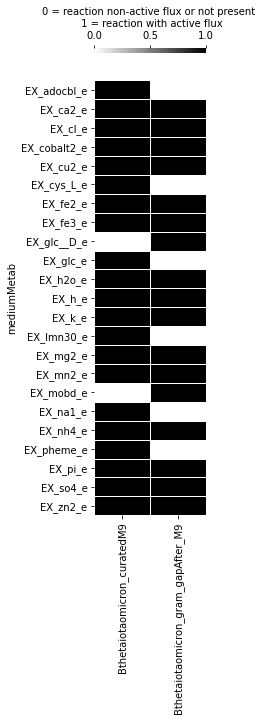

In [26]:
#glucose has a D in carveme models -> change this in curated?
dfsliced=df.copy()
dfsliced=dfsliced[["Bthetaiotaomicron_curatedM9", "Bthetaiotaomicron_gram_gapAfter_M9"]]
dfsliced['RowTotal'] = dfsliced.sum(axis=1)
dfsliced=dfsliced[dfsliced['RowTotal'] !=0]
dfsliced=dfsliced.drop(columns=['RowTotal'])
dfsliced=dfsliced.sort_index(ascending=True)
hm=mediumHeatmap(dfsliced)
hm

In [12]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9Series
M9List=M9Series.index.tolist()
M9List
# M9Series

['EX_adocbl(e)',
 'EX_ca2(e)',
 'EX_cobalt2(e)',
 'EX_cys_L(e)',
 'EX_fe2(e)',
 'EX_fe3(e)',
 'EX_k(e)',
 'EX_lmn30(e)',
 'EX_mg2(e)',
 'EX_mn2(e)',
 'EX_na1(e)',
 'EX_pheme(e)',
 'EX_pi(e)',
 'EX_zn2(e)']